In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

# Load data

In [3]:
file = '/Users/danichao/self_data/data_banknote_authentication.txt'
data = pd.read_csv(file, header=None, names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])
data

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


# Data Exploration

In [4]:
data.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [5]:
num_true = data['class'].sum()
ratio_true = num_true/len(data)

print("Number of true notes:", num_true)
print("Percentage of true notes:", ratio_true)

Number of true notes: 610
Percentage of true notes: 0.4446064139941691


Among the 1372 notes, 610 are true/real notes.

In [6]:
data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [7]:
data[data['class'] == 1].describe()

,variance,skewness,curtosis,entropy,class
count,610.000000,610.000000,610.000000,610.000000,610.0
mean,-1.868443,-0.993576,2.148271,-1.246641,1.0
std,1.881183,5.404884,5.261811,2.070984,0.0
min,-7.042100,-13.773100,-5.286100,-7.588700,1.0
25%,-3.061450,-5.810025,-1.357500,-2.458375,1.0
50%,-1.806100,0.172775,0.373720,-0.661650,1.0
75%,-0.541770,3.189275,5.626350,0.341790,1.0
max,2.391700,9.601400,17.927400,2.135300,1.0


In [8]:
data[data['class'] == 0].describe()

,variance,skewness,curtosis,entropy,class
count,762.000000,762.000000,762.000000,762.000000,762.0
mean,2.276686,4.256627,0.796718,-1.147640,0.0
std,2.019348,5.138792,3.239894,2.125077,0.0
min,-4.285900,-6.932100,-4.941700,-8.548200,0.0
25%,0.883345,0.450063,-1.709700,-2.228250,0.0
50%,2.553100,5.668800,0.700605,-0.552380,0.0
75%,3.884450,8.691975,2.652925,0.423257,0.0
max,6.824800,12.951600,8.829400,2.449500,0.0


Although we can see some trends in the descrbe tables, like true notes have lower `variance`, it is actually difficult to see a clear difference between true and fake notes among these four quantities, `variance`, `skewness`, `curtosis`, `and entropy`.

It is better to visualize the distribution of these four quantities.

# Visualization

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

In [10]:
def FeatureDistribution(feature):
    fig = plt.figure(figsize=(8,3.5))
    sns.kdeplot(data.loc[data['class'] == 0, feature], color='r', shade=True, label="Fake")
    sns.kdeplot(data.loc[data['class'] == 1, feature], color='b', shade=True, label="True",)
    plt.xlabel(feature)
    plt.ylabel('kernel density')
    plt.legend()
    plt.show()

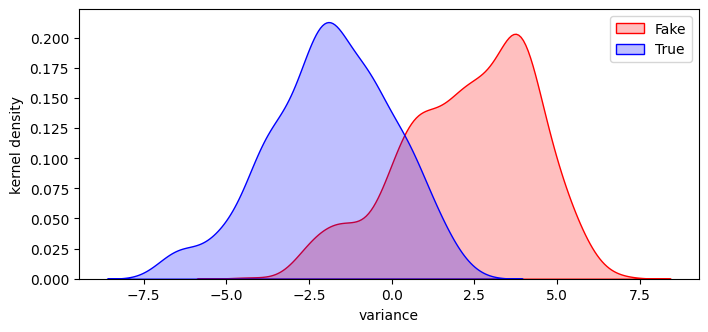

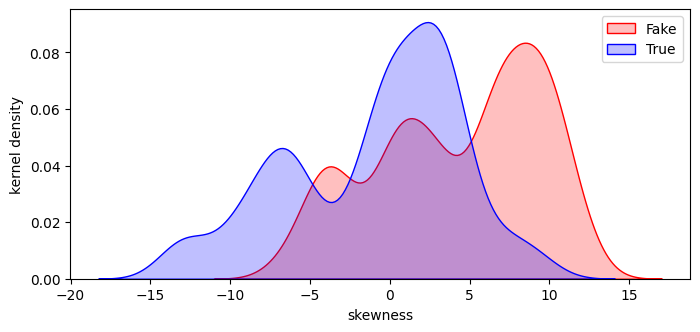

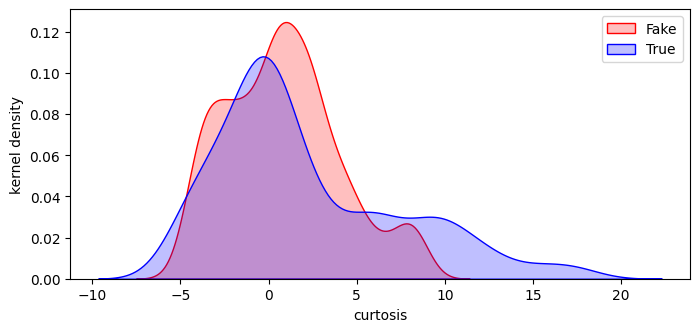

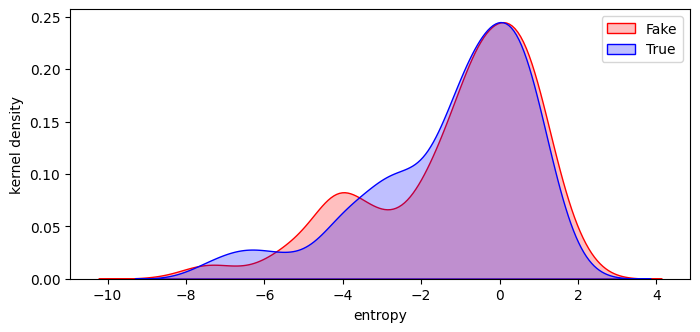

In [11]:
FeatureDistribution('variance')
FeatureDistribution('skewness')
FeatureDistribution('curtosis')
FeatureDistribution('entropy')

As the plots shown, true and fake notes overlap with each other among all four quantities, especially `entropy`. True and fake notes almost share same distribution on `entropy`. It suggests we need more sophisticated techniques to classify.

# Decide which features to use by checking the correlation among them

In [12]:
corr = data.corr()
corr

,variance,skewness,curtosis,entropy,class
variance,1.000000,0.264026,-0.380850,0.276817,-0.724843
skewness,0.264026,1.000000,-0.786895,-0.526321,-0.444688
curtosis,-0.380850,-0.786895,1.000000,0.318841,0.155883
entropy,0.276817,-0.526321,0.318841,1.000000,-0.023424
class,-0.724843,-0.444688,0.155883,-0.023424,1.000000


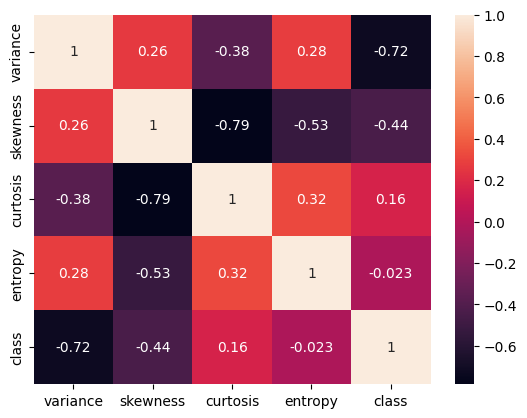

In [13]:
sns.heatmap(data.corr(), xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.show()

- `True-or-fake (class)` has nearly zero correlation with `entropy`.
- Although `true-or-fake` correlates with `variance` the most, `skewness` and `curtosis` also have non-negligible correlations with `true-or-fake`.
- Since `entropy` has sustantial correlation with all the other features, `variance`, `skewness`, and `curtosis`, we should probably not discard it even it has nearly zero correlation with `true-or-fake`.

#### We will need to experiment on classification with different sets of features, and see the test results to decide which is the best for true-fake note classification

# Logistic regression

Logistic regression is an easy and most common method to do binary classification. Compared to other classification methods/models, logistic regression is also faster and more straight-forward. I will evaluate the classification performance with true-positive rate (TPR) and false-positive rate (FPR).

Since features have various scales, I use `StandardScaler` to standardize/normalize the data to ensure the efficiency and quality of the modelling.

I use `GridSearchCV` to optimize the model by tuning the hyperparameters. 

## Use only variance and skewness to classify

Since `variance` and `skewness` are most correlated with `true-or-fake`, I first try use only these two features. If fewer features can already do a good-enough job, there is probably no need to use more features, given the concern of efficiency.

In [14]:
data_feature = data.drop(['curtosis', 'entropy'], axis=1)
data_feature.head()

,variance,skewness,class
0,3.62160,8.6661,0
1,4.54590,8.1674,0
2,3.86600,-2.6383,0
3,3.45660,9.5228,0
4,0.32924,-4.4552,0


### Model training preparation 

Here we first standardize the feature values and split the dataset into training set and test set.

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
# Standardization
x_features = data_feature.drop(['class'], axis=1)
y_label = data_feature['class'].values

scaler = StandardScaler()

x_features_scaled = pd.DataFrame(scaler.fit_transform(x_features), columns=x_features.columns)

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LogisticRegression

In [18]:
# Split into training set and test set
x_train, x_test, y_train, y_test =  train_test_split(x_features_scaled, y_label, test_size=0.3, random_state=0)

### Model training and hyperparameters tuning

Here we train the logistic regression model and tuning the hyperparameter, C, in the logistic regression model. The hyperparameter, C, decides the strength of regularization. (For logistic regression, we can also tune the regularization/penalty method, but for simplicity, I leave it to the default, which is l2.)

The model training and tuning will be evaluated by the Area Under the Receiver Operating Characteristic Curve (ROC AUC), a relation between TPR and FPR. ROC AUC score is between 0 and 1, the closer to 1 the better the classification.

In [19]:
# Define searching grid
C_grid = 0.001*10**(np.arange(0, 1.01, 0.01)*3)
parameters = {"C": C_grid}

In [20]:
# Train the model and tuning
lr = LogisticRegression()

grid_search = GridSearchCV(estimator=lr,
                           param_grid=parameters,
                           scoring='roc_auc', 
                           n_jobs=-1)

grid_search_result = grid_search.fit(x_train, y_train)

In [21]:
print("Best ROC AUC score:", grid_search_result.best_score_)
print("Optimized value of C:", grid_search_result.best_params_)

Best ROC AUC score: 0.9544537077665642
Optimized value of C: {'C': 0.0034673685045253167}


In [22]:
# Get the optimized model for evaluation
lr_optimized = grid_search_result.best_estimator_

### Evaluate the classification performance

Now we examine the classification performance through metrics like precision and accuracy. We also visualize the ROC AUC scores.

***Note: What logistic regression predict is the probability of a bank note to be true, which is the value `predict_proba` returns. `predict` returns the binary classification 0 (fake) or 1 (true) based on the mentioned probability and a threshold cut of the probability (fake < 0.5, true > 0.5).***

In [23]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score

In [24]:
def PerformanceReport(optimized_model, x_train, x_test, y_train, y_test):
    y_train_predict = optimized_model.predict(x_train)
    y_train_predict_prob = optimized_model.predict_proba(x_train)[:, 1] 

    y_test_predict = optimized_model.predict(x_test)
    y_test_predict_prob = optimized_model.predict_proba(x_test)[:, 1]

    train_confusion_mat = confusion_matrix(y_train, y_train_predict)
    test_confusion_mat = confusion_matrix(y_test, y_test_predict)

    train_tn, train_fp, train_fn, train_tp = train_confusion_mat.ravel()
    test_tn, test_fp, test_fn, test_tp = test_confusion_mat.ravel()

    print('Training true positive:', train_tp)
    print('Training false positive:', train_fp)
    print('Training true negative:', train_tn)
    print('Training false negative:', train_fn)
    print('\n')
    print('Test true positive:', test_tp)
    print('Test false positive:', test_fp)
    print('Test true negative:', test_tn)
    print('Test false negative:', test_fn)
    
    print('\n')
    print('=======')
    print('ROC AUC score of training set:', roc_auc_score(y_train, y_train_predict_prob))
    print('ROC AUC score of test set:', roc_auc_score(y_test, y_test_predict_prob))
    print('=======')
    print('Classification accuracy of training set:', accuracy_score(y_train, y_train_predict))
    print('Classification accuracy of test set:', accuracy_score(y_test, y_test_predict))
    print('=======')
    print('Classification precision of training set:', precision_score(y_train, y_train_predict))
    print('Classification precision of test set:', precision_score(y_test, y_test_predict))
    print('=======')
    print('Classification recall of training set:', recall_score(y_train, y_train_predict))
    print('Classification recall of test set:', recall_score(y_test, y_test_predict))
    print('=======')
    print('Classification f1 score of training set:', f1_score(y_train, y_train_predict))
    print('Classification f1 score of test set:', f1_score(y_test, y_test_predict))

In [25]:
def PlotROC(optimized_model, x_test, y_test):
    y_test_predict_prob = optimized_model.predict_proba(x_test)[:, 1]
    fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_test_predict_prob)
    test_roc_auc = roc_auc_score(y_test, y_test_predict_prob)

    fig = plt.figure()
    plt.plot(fpr_test, tpr_test, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Area = {:.2f})'.format(test_roc_auc))
    plt.show()

The reason I write functions here is to easily repeat the examination when we use different sets of features.

In [26]:
PerformanceReport(lr_optimized, x_train, x_test, y_train, y_test)

Training true positive: 329
Training false positive: 25
Training true negative: 505
Training false negative: 101


Test true positive: 142
Test false positive: 13
Test true negative: 219
Test false negative: 38


ROC AUC score of training set: 0.9549802544975866
ROC AUC score of test set: 0.9596503831417624
Classification accuracy of training set: 0.86875
Classification accuracy of test set: 0.8762135922330098
Classification precision of training set: 0.9293785310734464
Classification precision of test set: 0.9161290322580645
Classification recall of training set: 0.7651162790697674
Classification recall of test set: 0.7888888888888889
Classification f1 score of training set: 0.8392857142857143
Classification f1 score of test set: 0.8477611940298507


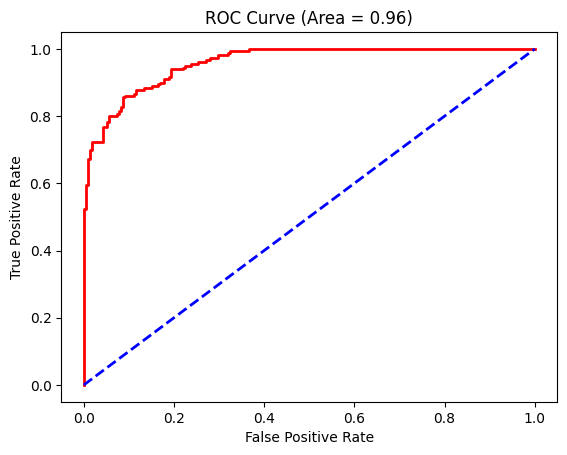

In [27]:
PlotROC(lr_optimized, x_test, y_test)

#### In the case of true/fake bank note classification, false positives are costy - if you are a shop owner, you would rather misclassify a true bank note as a fake ones and ask the customer to give you another one than accepting a fake bank note and losing money. (Recall is not very important in our case here.)

#### Although our logistic regression model with two features, `variance` and `skewness`, seems to be over-careful and tends to classify bank notes as fake ones, it actually works well in the sense that it really helps us not losing money!

## Using one more feature, curtosis

Now I want to see if I can have an even better logistic regression model by including `curtosis` in modeling. Since `curtosis` is more related with `true-or-fake` than `entropy`, I choose to include `curtosis`. 

In [28]:
# Include curtosis and repeat above
data_feature = data.drop(['entropy'], axis=1)

x_features = data_feature.drop(['class'], axis=1)
y_label = data_feature['class'].values

# Standardize/normalization
scaler = StandardScaler()
x_features_scaled = pd.DataFrame(scaler.fit_transform(x_features), columns=x_features.columns)

# Split into training and test sets
x_train, x_test, y_train, y_test =  train_test_split(x_features_scaled, y_label, test_size=0.3, random_state=0)

In [29]:
# Training model and tuning hyperparameters
lr_three_feature = LogisticRegression()

C_grid = 0.001*10**(np.arange(0, 1.01, 0.01)*3)
parameters = {"C": C_grid}

grid_search = GridSearchCV(estimator=lr_three_feature,
                           param_grid=parameters,
                           scoring='roc_auc', 
                           n_jobs=-1)

grid_search_result = grid_search.fit(x_train, y_train)

print("Best ROC AUC score:", grid_search_result.best_score_)
print("Optimized value of C:", grid_search_result.best_params_)

Best ROC AUC score: 0.9997367266344888
Optimized value of C: {'C': 0.5754399373371573}


By adding `curtosis`, the logistic regression model improves a lot! (from 0.95 to 0.99)

In [30]:
lr_three_feature_optimized = grid_search_result.best_estimator_

### Classification performance including curtosis

In [31]:
PerformanceReport(lr_three_feature_optimized, x_train, x_test, y_train, y_test)

Training true positive: 428
Training false positive: 16
Training true negative: 514
Training false negative: 2


Test true positive: 180
Test false positive: 7
Test true negative: 225
Test false negative: 0


ROC AUC score of training set: 0.9995831505046073
ROC AUC score of test set: 0.9998084291187739
Classification accuracy of training set: 0.98125
Classification accuracy of test set: 0.9830097087378641
Classification precision of training set: 0.963963963963964
Classification precision of test set: 0.9625668449197861
Classification recall of training set: 0.9953488372093023
Classification recall of test set: 1.0
Classification f1 score of training set: 0.9794050343249427
Classification f1 score of test set: 0.9809264305177112


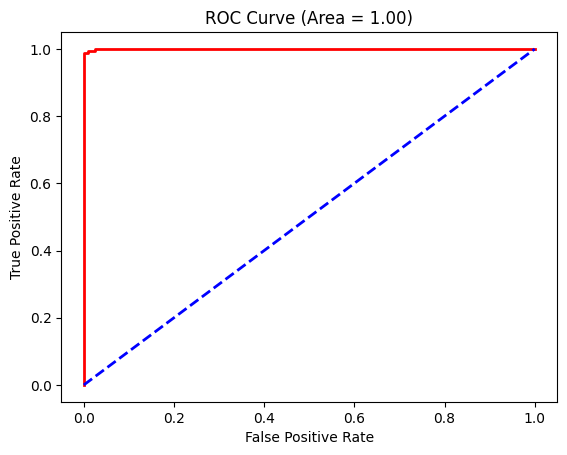

In [32]:
PlotROC(lr_three_feature_optimized, x_test, y_test)

After adding `curtosis`, we have an even better logistic regression model which works nearlly perfect!

The three-feature logistic regression model has a lower false-positive rate and a much lower false-negative rate that is nearlly zero! In other words, ***you will lose less money and get much less customer complaints (because you do not mis-reject their bank note). Your shop will get more five stars!*** 

### Although three features already work more than good enough, we can still check if entropy really helps us to reject all the fake notes

In [33]:
x_features = data.drop(['class'], axis=1)
y_label = data['class'].values

scaler = StandardScaler()
x_features_scaled = pd.DataFrame(scaler.fit_transform(x_features), columns=x_features.columns)

x_train, x_test, y_train, y_test =  train_test_split(x_features_scaled, y_label, test_size=0.3, random_state=0)

In [34]:
lr_total = LogisticRegression()

C_grid = 0.001*10**(np.arange(0, 1.01, 0.01)*3)
parameters = {"C": C_grid}

grid_search = GridSearchCV(estimator=lr_total,
                           param_grid=parameters,
                           scoring='roc_auc', 
                           n_jobs=-1)

grid_search_result = grid_search.fit(x_train, y_train)

print("Best ROC AUC score:", grid_search_result.best_score_)
print("Optimized value of C:", grid_search_result.best_params_)

Best ROC AUC score: 0.999692847740237
Optimized value of C: {'C': 1.0}


The same as using only three features, as expected.

In [35]:
lr_total_optimized = grid_search_result.best_estimator_

In [36]:
PerformanceReport(lr_total_optimized, x_train, x_test, y_train, y_test)

Training true positive: 428
Training false positive: 16
Training true negative: 514
Training false negative: 2


Test true positive: 180
Test false positive: 7
Test true negative: 225
Test false negative: 0


ROC AUC score of training set: 0.9996182536200088
ROC AUC score of test set: 0.9998563218390805
Classification accuracy of training set: 0.98125
Classification accuracy of test set: 0.9830097087378641
Classification precision of training set: 0.963963963963964
Classification precision of test set: 0.9625668449197861
Classification recall of training set: 0.9953488372093023
Classification recall of test set: 1.0
Classification f1 score of training set: 0.9794050343249427
Classification f1 score of test set: 0.9809264305177112


Exactly the same as using three features...

## Entropy is a redundant feature in the true/fake bank note classification 